# Section 1: binary phase evaluation (fixed parameters)

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent:

\begin{equation}
\label{eq:r_dot_DF_time}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}} \cdot r^{-5/2}\text{.}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and constants

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad 

In [5]:
# Define some constants: 

G = 6.67 * 10**(-11) # kg m^3 / s^2
c = 3 * 10**8 # m / s
pc = 3.09 * 10**16 # m
m_sun = 2 * 10**30 # kg

In [6]:
# Fix parameters:

m1 = 10**5 * m_sun #1.4e3 * m_sun
m2 = 10 * m_sun #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

# Spike: 

rho6 = 1.17 * 10**17 * m_sun / (pc)**3
r6 =  pc * 10**(-6)
gammas = 7/3
epsv = 0.58
logL = 1 / q**(1/2)

# Accretion disk: 

r_s = 2 * G * m1 / c**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5 * 10**10 / Mach**2
gamma = -1/2


r_isco = 6 * m1 * G / c**2 # of central bh

Set a grid of radial distances to plot quantities:

In [7]:
# Set a grid of radial distances

r_grid_0 = np.linspace(r_s, 250 * r_s, 10000)
r_grid = np.linspace(r_isco, 150 * r_isco, 10000)

### Note!

If we already integrate on the grid that starts from $\textit{isco}$ we are subtracting the $\Phi(f_{\mathrm{isco}}) = \int_{f_{\mathrm{isco}}}^{f_{\mathrm{isco}}} \frac{dt}{df} f' df' = 0$ to the phase $\Phi(f)$.

### Various functions: 

Down below I report the implementation of the functions we need. 

In [8]:
def rho_dm(r):
    
    '''Finds the density profile of the dark matter using the above formulation.'''
    
    return rho6 * (r6 / r)**(gammas)

In [9]:
def sigma_acc(r): 
    
    return sigma0 * (r / r0)**(gamma)

In [10]:
def rho_disk(r):
    
    '''Finds the density profile of the disk using \rho \simeq \Sigma(r)/(2h), where h = r / Mach.'''
    
    return sigma0 * (r / r0)**(gamma) / (2 * r / Mach) # set h = r / Mach

In [11]:
def frequency(r):
        
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        
    return 1 / np.pi * np.sqrt(G * M_tot / r**3)

In [12]:
def df_dr(r): 
    
    '''Finds the binary frequency radial derivative assuming circular orbits.'''
        
    return 1 / np.pi * (- 3 / 2) * np.sqrt(G * M_tot / r**5)

In [13]:
def df_dt(r, dot_r): # I left the expression of dot_r since I already evaluated it above, can be corrected to be a single function doing it all on its own 
    
    '''Finds the binary frequency time derivative.'''
    
    return df_dr(r) * dot_r

In [14]:
def gas_torque(r): 
    
    return - sigma_acc(r) * r**4 * (G * M_tot / r**3) * q**2 * Mach**2

In [15]:
def yes_or_no(elem):
    
    '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        
    if elem=='y': 
        
        return 1
    
    return 0

In [16]:
# The core function

def dot_r(r):
    
    '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
        
    acc = ''
    dm = ''
    gw = ''
    
    
    while(acc != 'y' and acc != 'n'):
        print('Include the accretion contribution? (y/n)')
        acc = input()
    
    while(dm != 'y' and dm != 'n'):
        print('Include the dark matter contribution? (y/n)')
        dm = input()
    
    while(gw != 'y' and gw != 'n'):
        print('Include the GW contribution? (y/n)')
        gw = input()
    
    r_dot_acc = 0.5 * gas_torque(r) * m2**(-1) * r**(1/2) * (G * M_tot)**(-1/2)
    
    r_dot_dm = - 8 * np.pi * G**(1/2) * m2 * logL * rho6 * r6**(gammas) * epsv / (r**(gammas - 5/2) * m1 * M_tot**(1/2)) #* r**(5/2)
    
    r_dot_gw = - 64 * M_tot * G**3 * m1 * m2 / (5 * c**5 * r**3)
    
    
    return yes_or_no(acc) * r_dot_acc + yes_or_no(dm) * r_dot_dm + yes_or_no(gw) * r_dot_gw

In [17]:
def phase_f_by_hand(df_dt): 
    
    '''Finds the binary phase as a function of frequency.'''
    
    freqs = frequency(r_grid)
    to_integrate = 2 * np.pi * df_dt**(-1) * freqs 
    phase_f = []
    
    for b in freqs:  # range of values for the lower limit
        
        # Select the appropriate range of f values for integration
        f_range = freqs[freqs >= b]
        
        phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))

    return np.array(phase_f)

In [18]:
def phase_f(df_dt): 
    
    '''Finds the binary phase as a function of frequency'''
    
    freqs = frequency(r_grid)
    to_integrate = 2 * np.pi * df_dt**(-1) * freqs 
    phase = sp.integrate.cumulative_trapezoid(to_integrate, freqs)
    
    return np.array(phase)

In [19]:
def ddot_phase_f(df_dt): 
    
    '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
    
    return 2 * np.pi * df_dt

In [20]:
def h_0(f, ddot_phase):
    
    '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
    
    return 1/2 * 4 * np.pi**(2/3) * G**(5/3) * chirp_mass**(5/3) * f**(2/3) / c**4 * (2 * np.pi / ddot_phase)**(1/2) / (4 * 10**9 * pc)

### Some plots:

- Density profiles:

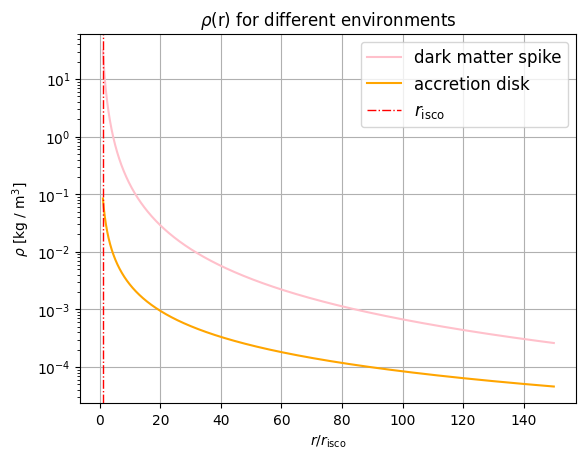

In [21]:
plt.semilogy(r_grid/r_isco, rho_dm(r_grid), c='pink', linestyle='-', label='dark matter spike')
plt.semilogy(r_grid/r_isco, rho_disk(r_grid), c='orange', linestyle='-', label='accretion disk')
plt.axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
plt.xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\rho$ [kg / m$^3$]', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.title(r'$\rho$(r) for different environments', fontsize=12)
plt.grid(True)  # Add gridlines
plt.legend(fontsize='large')  # Add legend
plt.show()

- Frequency:

In [22]:
# Check the frequencies are ok:

freqs = frequency(r_grid)
f_isco = frequency(r_isco)

print('f_isco:', f_isco)
print('f_isco_grid:', freqs[0])

f_isco: 0.04383821880242686
f_isco_grid: 0.04383821880242686


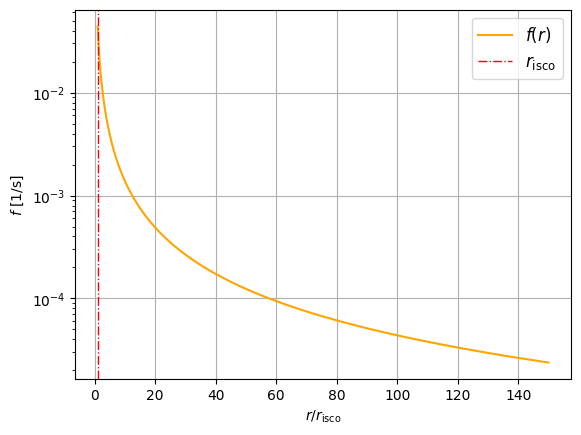

In [23]:
plt.semilogy(r_grid/r_isco, freqs, c='orange', linestyle='-', label='$f(r)$')
plt.axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1) # 1 = r_isco / r_isco
plt.xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
plt.ylabel('$f$ [1/s]', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend(fontsize='large')
plt.show()

- Frequency radial derivative:

In [24]:
df_dr_s = df_dr(r_grid_0)

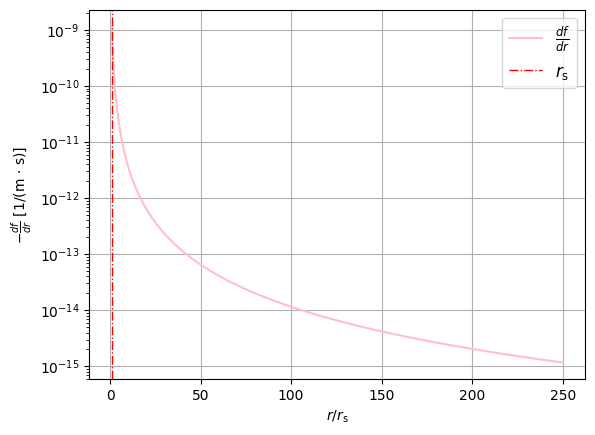

In [25]:
plt.semilogy(r_grid_0/r_s, -df_dr_s, c='pink', linestyle='-', label=r'$\frac{df}{dr}$')
plt.axvline(x=1, c='red', label=r'$r_{\mathrm{s}}$', linestyle='-.', linewidth=1)
plt.xlabel(r'$r/r_{\mathrm{s}}$', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$-\frac{df}{dr}$ [1/(m $\cdot$ s)]', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend(fontsize='large')  # Add legend
plt.show()

- Time derivative of the radial separation: 

In [26]:
dot_r_all = dot_r(r_grid)

Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y


In [27]:
dot_r_acc = dot_r(r_grid)

Include the accretion contribution? (y/n)
y
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y


In [29]:
dot_r_dm = dot_r(r_grid)

Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y


In [30]:
dot_r_gw = dot_r(r_grid)

Include the accretion contribution? (y/n)
n
Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y


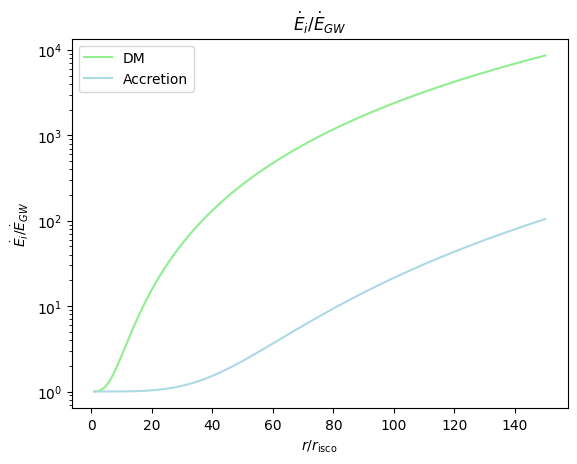

In [31]:
plt.semilogy(r_grid/r_isco, dot_r_dm/dot_r_gw, c='lightgreen', label='DM')
plt.semilogy(r_grid/r_isco, dot_r_acc/dot_r_gw, c='lightblue', label='Accretion')
#plt.ylim(10**-3, 10**2)
plt.title("$\dot{E}_i / \dot{E}_{GW}$")
plt.ylabel("$\dot{E}_i / \dot{E}_{GW}$")
plt.xlabel("$r/r_{\mathrm{isco}}$")
plt.legend();

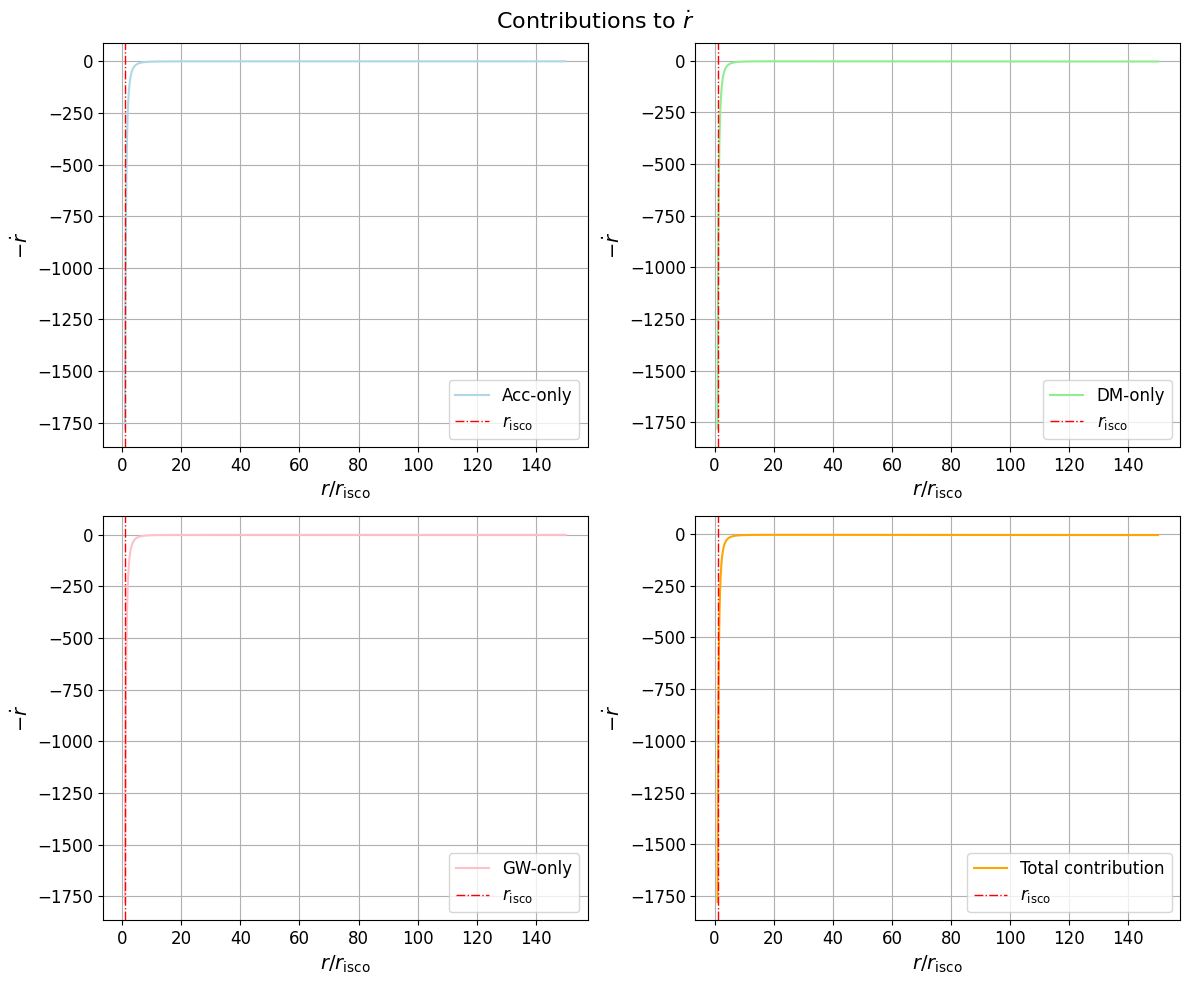

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\dot{r}$', fontsize=16)

axs[0, 0].plot(r_grid/r_isco, dot_r_acc, c='lightblue', linestyle='-', label='Acc-only')
axs[0, 0].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 0].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=14)  # Increase x-label font size
axs[0, 0].set_ylabel('$-\dot{r}$', fontsize=14)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend(fontsize='large')  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].plot(r_grid/r_isco, dot_r_dm, c='lightgreen', linestyle='-', label='DM-only')
axs[0, 1].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 1].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=14)  # Increase x-label font size
axs[0, 1].set_ylabel('$-\dot{r}$', fontsize=14)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend(fontsize='large')  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].plot(r_grid/r_isco, dot_r_gw, c='pink', linestyle='-', label='GW-only')
axs[1, 0].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 0].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=14)  # Increase x-label font size
axs[1, 0].set_ylabel('$-\dot{r}$', fontsize=14)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend(fontsize='large')  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].plot(r_grid/r_isco, dot_r_all, c='orange', linestyle='-', label='Total contribution')
axs[1, 1].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 1].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=14)  # Increase x-label font size
axs[1, 1].set_ylabel('$-\dot{r}$', fontsize=14)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend(fontsize='large')  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.tight_layout()
plt.show()

- Phase: adopt two methods and compare their outcome.

In [33]:
df_dt_all = df_dt(r_grid, dot_r_all)
df_dt_acc = df_dt(r_grid, dot_r_acc)
df_dt_dm = df_dt(r_grid, dot_r_dm)
df_dt_gw = df_dt(r_grid, dot_r_gw)

phi_all_bh = phase_f_by_hand(df_dt_all)
phi_acc_bh = phase_f_by_hand(df_dt_acc)
phi_dm_bh = phase_f_by_hand(df_dt_dm)
phi_gw_bh = phase_f_by_hand(df_dt_gw)

phi_all = phase_f(df_dt_all)
phi_acc = phase_f(df_dt_acc)
phi_dm = phase_f(df_dt_dm)
phi_gw = phase_f(df_dt_gw)

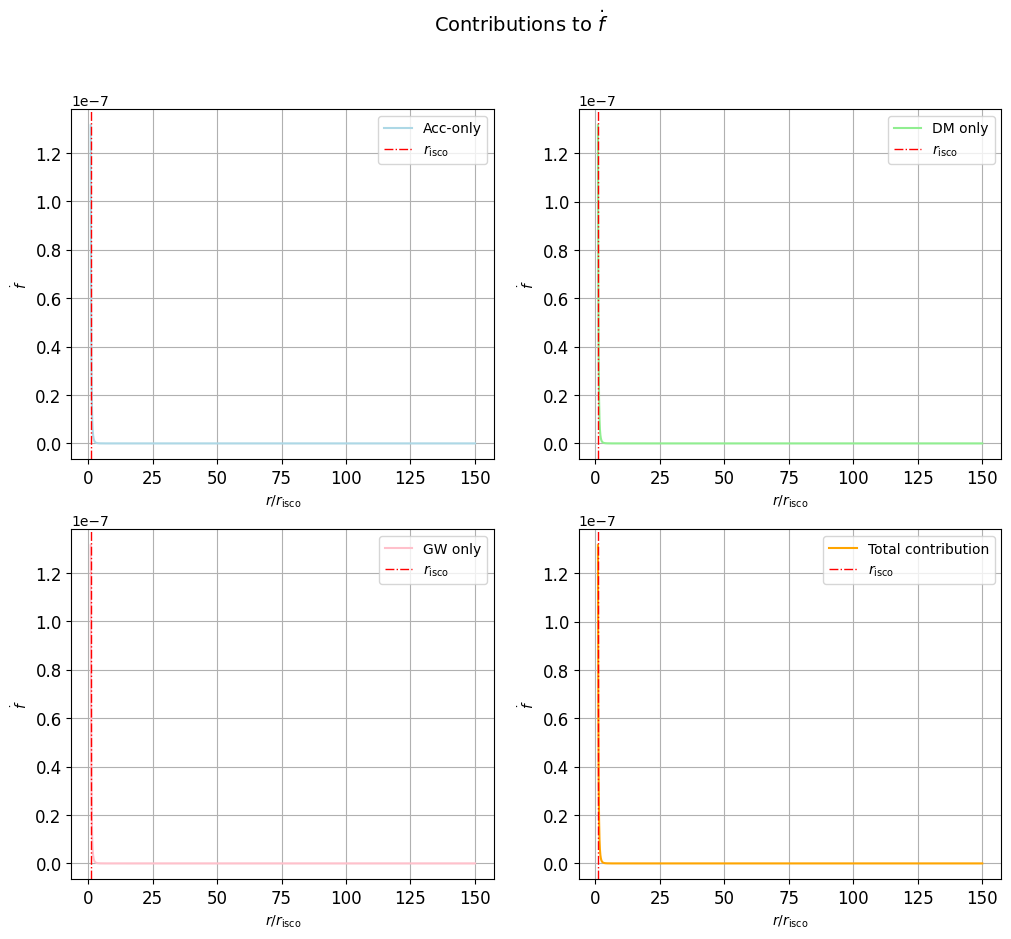

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\dot{f}$', fontsize=14)


axs[0, 0].plot(r_grid/r_isco, df_dt_acc, c='lightblue', linestyle='-', label='Acc-only')
axs[0, 0].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 0].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$\dot{f}$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].plot(r_grid/r_isco, df_dt_dm, c='lightgreen', linestyle='-', label='DM only')
axs[0, 1].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 1].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$\dot{f}$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].plot(r_grid/r_isco, df_dt_gw, c='pink', linestyle='-', label='GW only')
axs[1, 0].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 0].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$\dot{f}$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].plot(r_grid/r_isco, df_dt_all, c='orange', linestyle='-', label='Total contribution')
axs[1, 1].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 1].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$\dot{f}$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

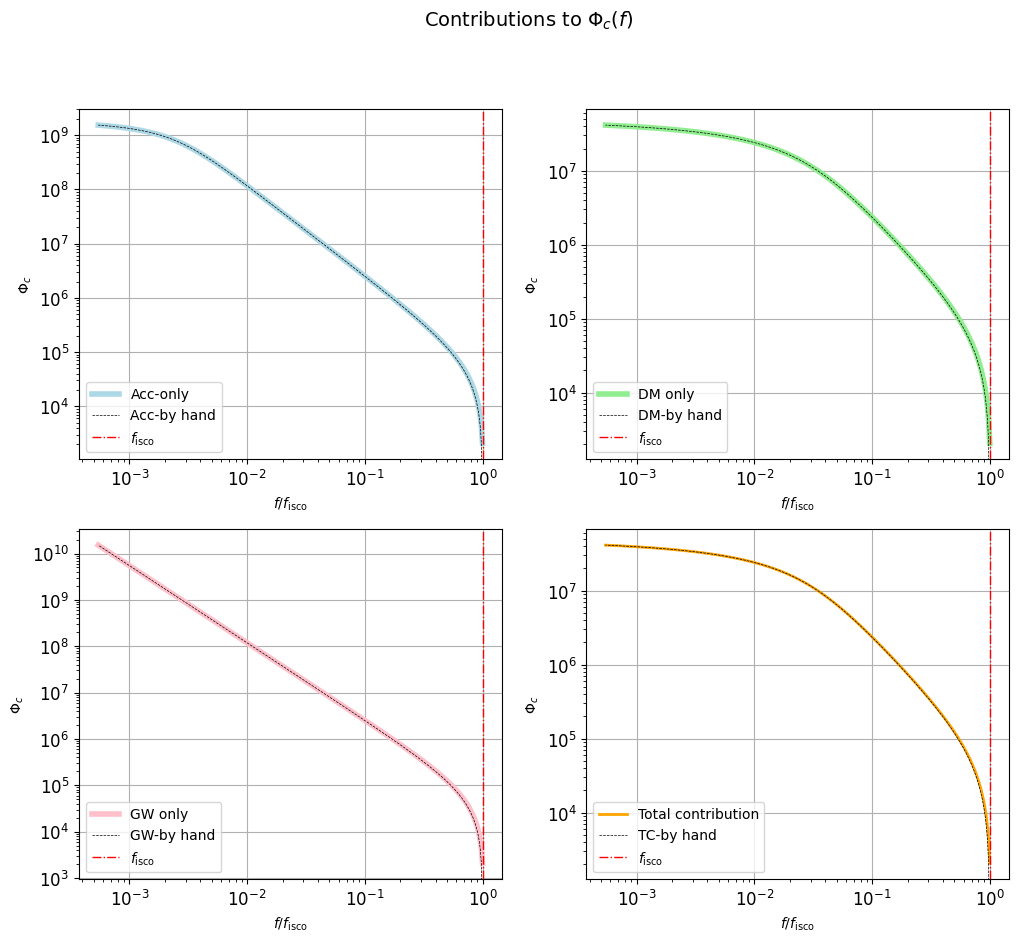

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)


axs[0, 0].loglog(freqs[:-1]/f_isco, -phi_acc, c='lightblue', linestyle='-', label='Acc-only', linewidth=4)
axs[0, 0].loglog(freqs/f_isco, -phi_acc_bh, c='black', linestyle='--', label='Acc-by hand', linewidth=0.5)
axs[0, 0].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].loglog(freqs[:-1]/f_isco, -phi_dm, c='lightgreen', linestyle='-', label='DM only', linewidth=4)
axs[0, 1].loglog(freqs/f_isco, -phi_dm_bh, c='black', linestyle='--', label='DM-by hand', linewidth=0.5)
axs[0, 1].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].loglog(freqs[:-1]/f_isco, -phi_gw, c='pink', linestyle='-', label='GW only', linewidth=4)
axs[1, 0].loglog(freqs/f_isco, -phi_gw_bh, c='black', linestyle='--', label='GW-by hand', linewidth=0.5)
axs[1, 0].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].loglog(freqs[:-1]/f_isco, -phi_all, c='orange', linestyle='-', label='Total contribution', linewidth=2)
axs[1, 1].loglog(freqs/f_isco, -phi_all_bh, c='black', linestyle='--', label='TC-by hand', linewidth=0.5)
axs[1, 1].axvline(x=1, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1, 1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

See them in a single plot:

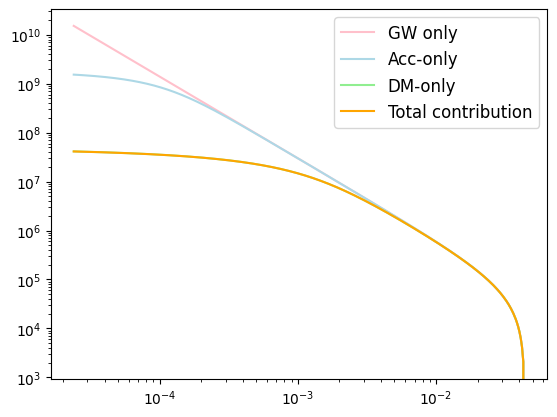

In [36]:
plt.loglog(freqs, -phi_gw_bh, c='pink', label='GW only')
plt.loglog(freqs, -phi_acc_bh, c='lightblue', label='Acc-only')
plt.loglog(freqs, -phi_dm_bh, c='lightgreen', label='DM-only')
plt.loglog(freqs, -phi_all_bh, c='orange', label='Total contribution')
plt.legend(fontsize='large');

- Difference in phase between vacuum case and environment cases $(\Phi_{\mathrm{GW}} - \Phi_{\mathrm{env}}) / 2\pi$: 

In [37]:
a=[4.54e-3, 1.37e+1]
b=[1.16e-2, 2.24e-1]
d=[2.47e-2, 7.82e-3]

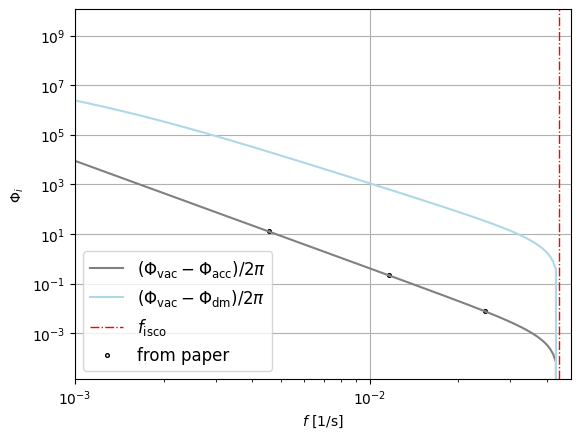

In [38]:
plt.loglog(freqs, (+phi_acc_bh - phi_gw_bh)/(2 * np.pi), c='grey', label='$(\Phi_{\mathrm{vac}} - \Phi_{\mathrm{acc}}) / 2\pi$')
plt.loglog(freqs, (+phi_dm_bh - phi_gw_bh)/(2 * np.pi), c='lightblue', label='$(\Phi_{\mathrm{vac}} - \Phi_{\mathrm{dm}}) / 2\pi$')
plt.axvline(x=f_isco, c='red', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
plt.xlabel('$f$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\Phi_i$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)
plt.scatter(*a, marker='o', c='white', s=7, edgecolor='black')
plt.scatter(*b, marker='o', c='white', s=7, edgecolor='black')
plt.scatter(*d, marker='o',  c='white', s=7, edgecolor='black', label='from paper')
plt.tick_params(axis='y', which='minor')
plt.xlim(10**(-3), 1.1 * f_isco)
plt.legend(fontsize='large');

### Testing the code on the analytical solution I found

Which is just the GW case.

In [39]:
phi_gw_an = -G**(-5/3) * (M_tot)**(1/3) * c**5 / (16 * np.pi**(5/3) * m1 * m2) * (freqs**(-5/3) - f_isco**(-5/3))

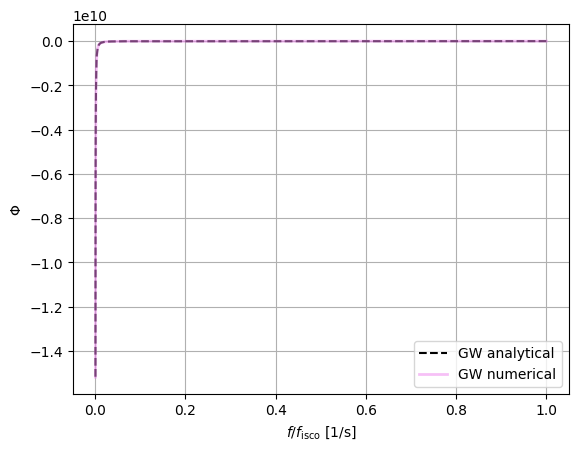

In [40]:
plt.plot(freqs/f_isco, phi_gw_an, c='black', linestyle='--', label='GW analytical', linewidth=1.5)
plt.plot(freqs/f_isco, phi_gw_bh, c='violet', linestyle='-', label='GW numerical', alpha=0.5, linewidth=2)
plt.xlabel('$f/f_{\mathrm{isco}}$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\Phi$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend();

This is so nice! Let's find the second derivative of the phase $\Phi$, for all the contributions: 

In [41]:
ddot_phase_all = ddot_phase_f(df_dt_all)
ddot_phase_acc = ddot_phase_f(df_dt_acc)
ddot_phase_dm = ddot_phase_f(df_dt_dm)
ddot_phase_gw = ddot_phase_f(df_dt_gw)

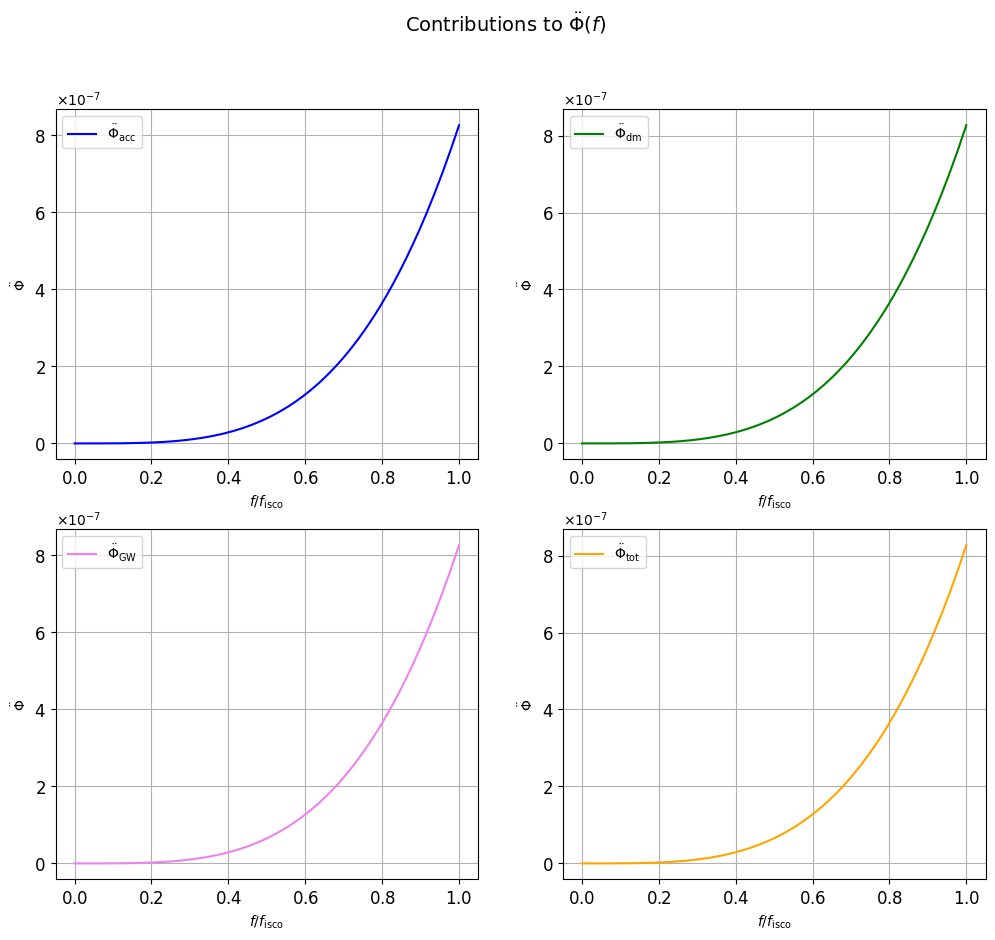

In [42]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $\ddot{\Phi}(f)$', fontsize=14)


axs[0, 0].plot(freqs/f_isco, ddot_phase_acc, c='blue', linestyle='-', label='$\ddot{\Phi}_{\mathrm{acc}}$', linewidth=1.5)
axs[0, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].plot(freqs/f_isco, ddot_phase_dm, c='green', linestyle='-', label='$\ddot{\Phi}_{\mathrm{dm}}$', linewidth=1.5)
axs[0, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].plot(freqs/f_isco, ddot_phase_gw, c='violet', linestyle='-', label='$\ddot{\Phi}_{\mathrm{GW}}$', linewidth=1.5)
axs[1, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].plot(freqs/f_isco, ddot_phase_all, c='orange', linestyle='-', label='$\ddot{\Phi}_{\mathrm{tot}}$', linewidth=1.5)
axs[1, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

### Testing the code on the analytical solution I found

Which, again, is just the GW case.

In [43]:
ddot_phi_gw_an = 12 * np.pi**2 * G**(5/3) * (M_tot)**(-1/3) * c**(-5) * (16 * np.pi**(5/3) * m1 * m2) / 5 * (freqs**(11/3))

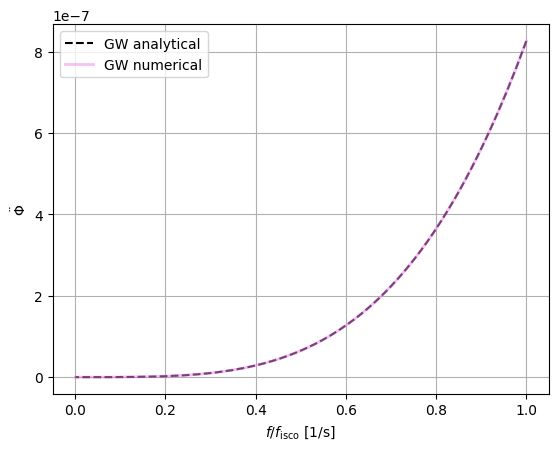

In [44]:
plt.plot(freqs/f_isco, ddot_phi_gw_an, c='black', linestyle='--', label='GW analytical', linewidth=1.5)
plt.plot(freqs/f_isco, ddot_phase_gw, c='violet', linestyle='-', label='GW numerical', alpha=0.5, linewidth=2)
plt.xlabel('$f/f_{\mathrm{isco}}$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\ddot{\Phi}$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend();

### Finding $h_0$

In [45]:
h_0_all = h_0(freqs, ddot_phase_all)
h_0_acc = h_0(freqs, ddot_phase_acc)
h_0_dm = h_0(freqs, ddot_phase_dm)
h_0_gw = h_0(freqs, ddot_phase_gw)

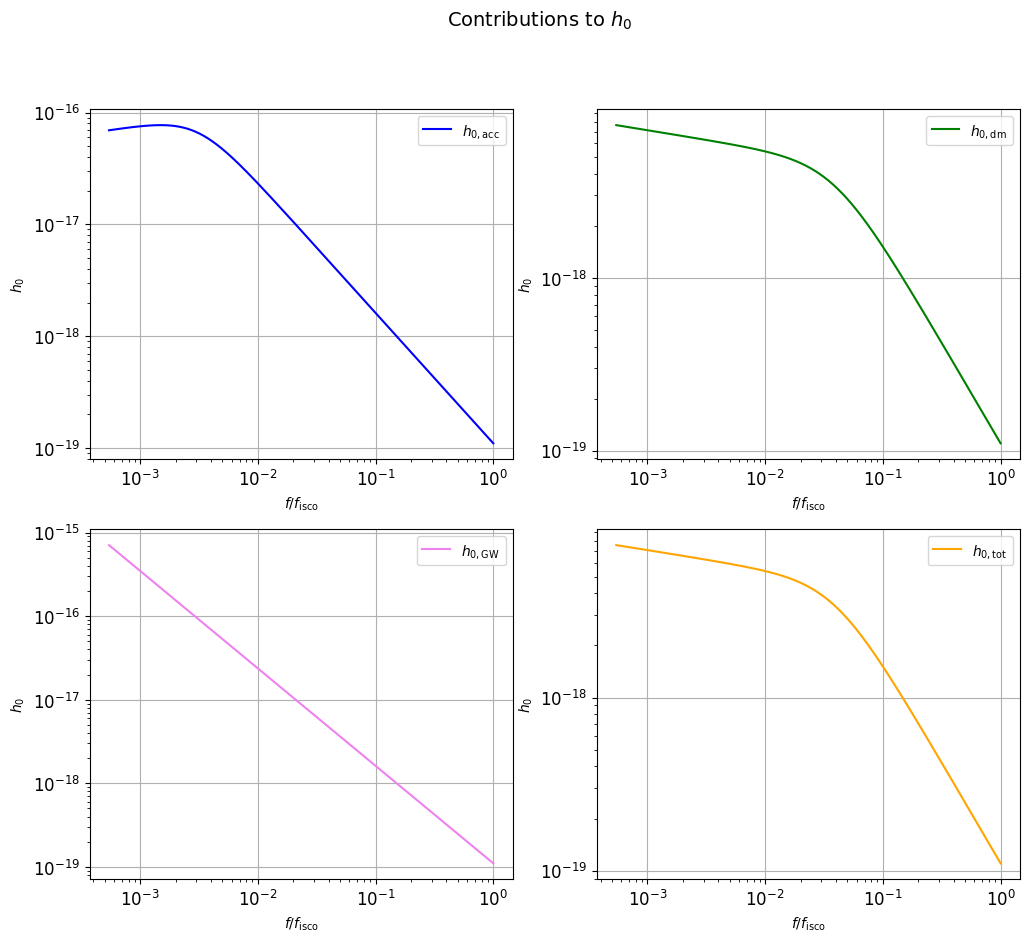

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12,10))

plt.suptitle('Contributions to $h_0$', fontsize=14)


axs[0, 0].loglog(freqs/f_isco, h_0_acc, c='blue', linestyle='-', label='$h_{0, \mathrm{acc}}$', linewidth=1.5)
axs[0, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 0].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[0, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 0].grid(True)  # Add gridlines
axs[0, 0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[0, 1].loglog(freqs/f_isco, h_0_dm, c='green', linestyle='-', label='$h_{0, \mathrm{dm}}$', linewidth=1.5)
axs[0, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[0, 1].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[0, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0, 1].grid(True)  # Add gridlines
axs[0, 1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 0].loglog(freqs/f_isco, h_0_gw, c='violet', linestyle='-', label='$h_{0, \mathrm{GW}}$', linewidth=1.5)
axs[1, 0].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 0].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[1, 0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 0].grid(True)  # Add gridlines
axs[1, 0].legend()  # Add legend
#axs[1, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1, 1].loglog(freqs/f_isco, h_0_all, c='orange', linestyle='-', label='$h_{0, \mathrm{tot}}$', linewidth=1.5)
axs[1, 1].set_xlabel('$f/f_\mathrm{isco}$', fontsize=10)  # Increase x-label font size
axs[1, 1].set_ylabel(r'$h_0$', fontsize=10)  # Add y-label with increased font size
axs[1, 1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1, 1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1, 1].grid(True)  # Add gridlines
axs[1, 1].legend()  # Add legend
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

---

# Section 2: binary phase evaluation VARYING parameters

We now work using the same functions as in the previous section, only varying parameters one by one. More specifically we'll change:

### For the accretion disk:

- The $\gamma$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk;
- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the dark matter spike:

- The $\gamma_s$ parameter (?);
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

An interesting POV is to find as a threshold the values of densities normalizations such that $\Delta\Phi < 2\pi$ (MY IDEA: set the $\texttt{r_dot}$ such that the normalizations get out of the dephasing and then set $\Sigma = \Delta\Phi / \Delta\Phi_{\mathrm{fake}}$).  

In [48]:
# Build array of gamma values, rho_m, and m_s

gamma_vals = np.linspace(-0.4, -0.7, 40)
m1_vals = np.logspace(3, 6, 40)
#gamma_vals = np.logspace(,, 40)

print("Gammas: ", gamma_vals)
print("M1s: ", m1_vals)
#print("Rhos: ", gamma_vals)

Gammas:  [-0.4        -0.40769231 -0.41538462 -0.42307692 -0.43076923 -0.43846154
 -0.44615385 -0.45384615 -0.46153846 -0.46923077 -0.47692308 -0.48461538
 -0.49230769 -0.5        -0.50769231 -0.51538462 -0.52307692 -0.53076923
 -0.53846154 -0.54615385 -0.55384615 -0.56153846 -0.56923077 -0.57692308
 -0.58461538 -0.59230769 -0.6        -0.60769231 -0.61538462 -0.62307692
 -0.63076923 -0.63846154 -0.64615385 -0.65384615 -0.66153846 -0.66923077
 -0.67692308 -0.68461538 -0.69230769 -0.7       ]
M1s:  [   1000.            1193.77664171    1425.1026703     1701.25427985
    2030.9176209     2424.46201708    2894.26612472    3455.10729459
    4124.6263829     4923.88263171    5878.01607227    7017.0382867
    8376.77640068   10000.           11937.76641714   14251.02670303
   17012.54279853   20309.17620905   24244.62017082   28942.66124717
   34551.07294592   41246.26382901   49238.82631707   58780.16072275
   70170.38286704   83767.76400683  100000.          119377.66417144
  142510.267030

In [ ]:
# Find the 